# CDC Diabetes Dataset - Classification Model Analysis

## 📋 Project Overview

This notebook builds and evaluates machine learning classification models to predict diabetes status using the CDC Diabetes Dataset. The analysis includes:

- **Exploratory Data Analysis (EDA)**: Understanding dataset characteristics, distributions, correlations, and class imbalance
- **Data Preprocessing**: Feature scaling and train-test splitting
- **Model Building**: Training three classification models:
  - Logistic Regression
  - Random Forest Classifier
  - XGBoost Classifier
- **Model Evaluation**: Comprehensive performance metrics and cross-validation
- **Model Improvement**: Strategies to handle class imbalance and improve recall

## 🎯 Objective

Predict diabetes status (No Diabetes, Prediabetes, Diabetes) from health indicators. Special focus on improving recall for diabetes cases since missing a diabetes diagnosis is clinically more dangerous than false alarms.

## 📊 Dataset Information

- **Source**: CDC Behavioral Risk Factor Surveillance System (BRFSS)
- **Records**: 253,680 survey responses
- **Features**: 21 health-related variables
- **Target**: Diabetes_012 (3 classes: 0=No, 1=Prediabetes, 2=Diabetes)
- **Class Balance**: Highly imbalanced (84% No Diabetes, 14% Diabetes, 2% Prediabetes)

---

## Step 1: Import Libraries

We import all necessary Python libraries for data analysis, visualization, and machine learning.

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve,
                             precision_recall_curve, f1_score, 
                             balanced_accuracy_score)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 2: Load and Explore Dataset

Load the CDC Diabetes Dataset and display basic information about its structure, shape, and first few records.

In [11]:
# Load the dataset
df = pd.read_csv(r'E:\WarWick\FAIDM module\Individual Assignment\CDC Diabetes Dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (253680, 22)

First few rows:
   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      1

In [12]:
df.duplicated().sum

<bound method Series.sum of 0         False
1         False
2         False
3         False
4         False
          ...  
253675    False
253676    False
253677    False
253678    False
253679    False
Length: 253680, dtype: bool>

In [13]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

np.int64(0)

## Step 3: Exploratory Data Analysis (EDA)

Conduct comprehensive EDA including:
- **Missing Values**: Check data completeness
- **Target Variable**: Analyze class distribution and identify imbalance
- **Features**: Examine statistical properties, distributions, and relationships
- **Correlations**: Identify features most correlated with diabetes

In [14]:
# ============================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

# 1. Check for missing values
print("=" * 60)
print("1. MISSING VALUES ANALYSIS")
print("=" * 60)
missing_values = df.isnull().sum()
print(f"Missing values:\n{missing_values.sum()} total missing values")
if missing_values.sum() == 0:
    print("✓ No missing values detected!")
print()

1. MISSING VALUES ANALYSIS
Missing values:
0 total missing values
✓ No missing values detected!



### 3.1 Target Variable Distribution

Analyze the distribution of the target variable (Diabetes_012) across three classes:
- Class 0: No Diabetes (majority class)
- Class 1: Prediabetes (smallest class)
- Class 2: Diabetes (minority class)

**Key Insight**: The dataset shows significant class imbalance (84% vs 14% vs 2%), which requires special consideration during model training.

2. TARGET VARIABLE ANALYSIS - Diabetes_012

Class Distribution (Counts):
  Class 0 (No Diabetes): 190,055 (82.71%)
  Class 1 (Prediabetes): 4,629 (2.01%)
  Class 2 (Diabetes): 35,097 (15.27%)

Class Imbalance Ratio:
  Majority class: 190,055
  Minority class: 4,629
  Imbalance ratio: 1:41.06


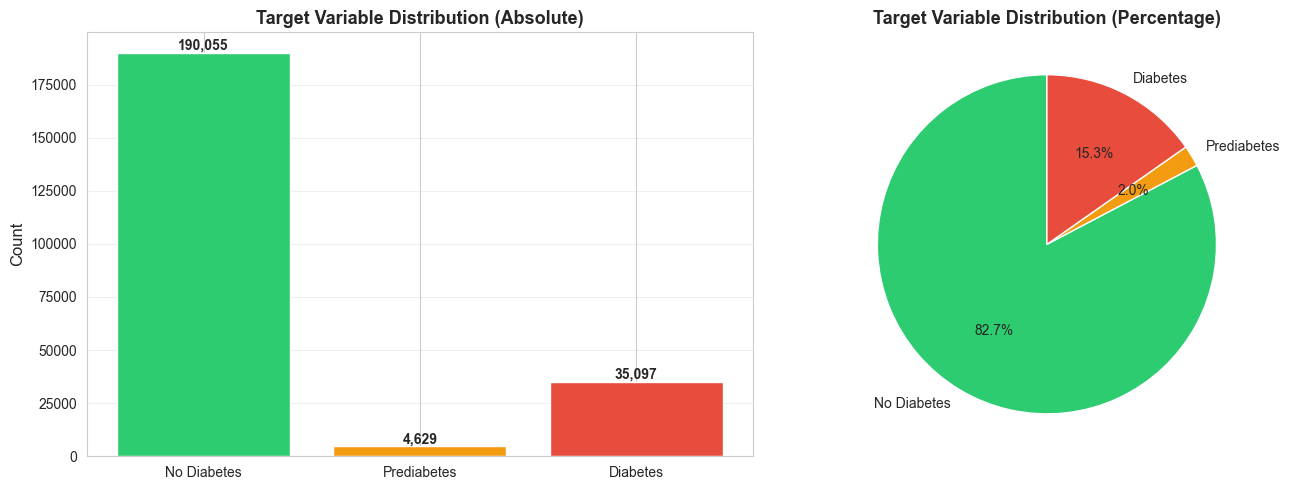

In [15]:
# 2. Target Variable Analysis
print("=" * 60)
print("2. TARGET VARIABLE ANALYSIS - Diabetes_012")
print("=" * 60)

target_counts = df['Diabetes_012'].value_counts().sort_index()
target_pcts = df['Diabetes_012'].value_counts(normalize=True).sort_index() * 100

print("\nClass Distribution (Counts):")
labels = ['No Diabetes', 'Prediabetes', 'Diabetes']
for idx, label in enumerate(labels):
    print(f"  Class {idx} ({label}): {target_counts[idx]:,} ({target_pcts[idx]:.2f}%)")

# Class imbalance ratio
print(f"\nClass Imbalance Ratio:")
print(f"  Majority class: {target_counts.max():,}")
print(f"  Minority class: {target_counts.min():,}")
print(f"  Imbalance ratio: 1:{target_counts.max()/target_counts.min():.2f}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(labels, target_counts.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Target Variable Distribution (Absolute)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1].pie(target_counts.values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Target Variable Distribution (Percentage)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print()

### 3.2 Feature Statistics and Skewness

Analyze numerical features including:
- **Descriptive Statistics**: Mean, std, min/max values
- **Skewness**: Measure of distribution asymmetry (-0.5 to 0.5 = symmetric, >0.5 = right-skewed, <-0.5 = left-skewed)
- **Kurtosis**: Measure of tail heaviness (higher = more extreme values)
- **Variance & Range**: Feature variability and spread

In [16]:
# 3. Feature Analysis
print("=" * 60)
print("3. FEATURE ANALYSIS")
print("=" * 60)

# Separate features from target
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print(f"\nNumber of Features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

# Numerical statistics
print("\n" + "=" * 60)
print("3.1 NUMERICAL FEATURES STATISTICS")
print("=" * 60)
print(X.describe().round(3))

print("\n" + "=" * 60)
print("3.2 SKEWNESS AND KURTOSIS ANALYSIS")
print("=" * 60)

skewness_data = []
for col in X.columns:
    skew = stats.skew(X[col])
    kurt = stats.kurtosis(X[col])
    skewness_data.append({
        'Feature': col,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Skew Type': 'Right-skewed' if skew > 0.5 else ('Left-skewed' if skew < -0.5 else 'Approximately Symmetric')
    })

skewness_df = pd.DataFrame(skewness_data).sort_values('Skewness', key=abs, ascending=False)
print(skewness_df.to_string(index=False))

print("\n" + "=" * 60)
print("3.3 FEATURE VARIANCE AND RANGE")
print("=" * 60)

variance_data = []
for col in X.columns:
    variance_data.append({
        'Feature': col,
        'Min': X[col].min(),
        'Max': X[col].max(),
        'Mean': X[col].mean(),
        'Std Dev': X[col].std(),
        'Variance': X[col].var(),
        'Range': X[col].max() - X[col].min()
    })

variance_df = pd.DataFrame(variance_data).sort_values('Std Dev', ascending=False)
print(variance_df.round(3).to_string(index=False))

print()

3. FEATURE ANALYSIS

Number of Features: 21
Feature names: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

3.1 NUMERICAL FEATURES STATISTICS
           HighBP    HighChol   CholCheck         BMI      Smoker      Stroke  \
count  229781.000  229781.000  229781.000  229781.000  229781.000  229781.000   
mean        0.454       0.442       0.960      28.686       0.466       0.045   
std         0.498       0.497       0.197       6.786       0.499       0.207   
min         0.000       0.000       0.000      12.000       0.000       0.000   
25%         0.000       0.000       1.000      24.000       0.000       0.000   
50%         0.000       0.000       1.000      27.000       0.000       0.000   
75%         1.000       1.000       1.000      32.000       1.000       0.000 

### 3.3 Feature Distributions

Visualize the distribution of each feature using histograms with skewness indicators. This helps identify:
- Outliers and extreme values
- Distribution shape (normal, skewed, bimodal, etc.)
- Features needing transformation or scaling

4. FEATURE DISTRIBUTION VISUALIZATION


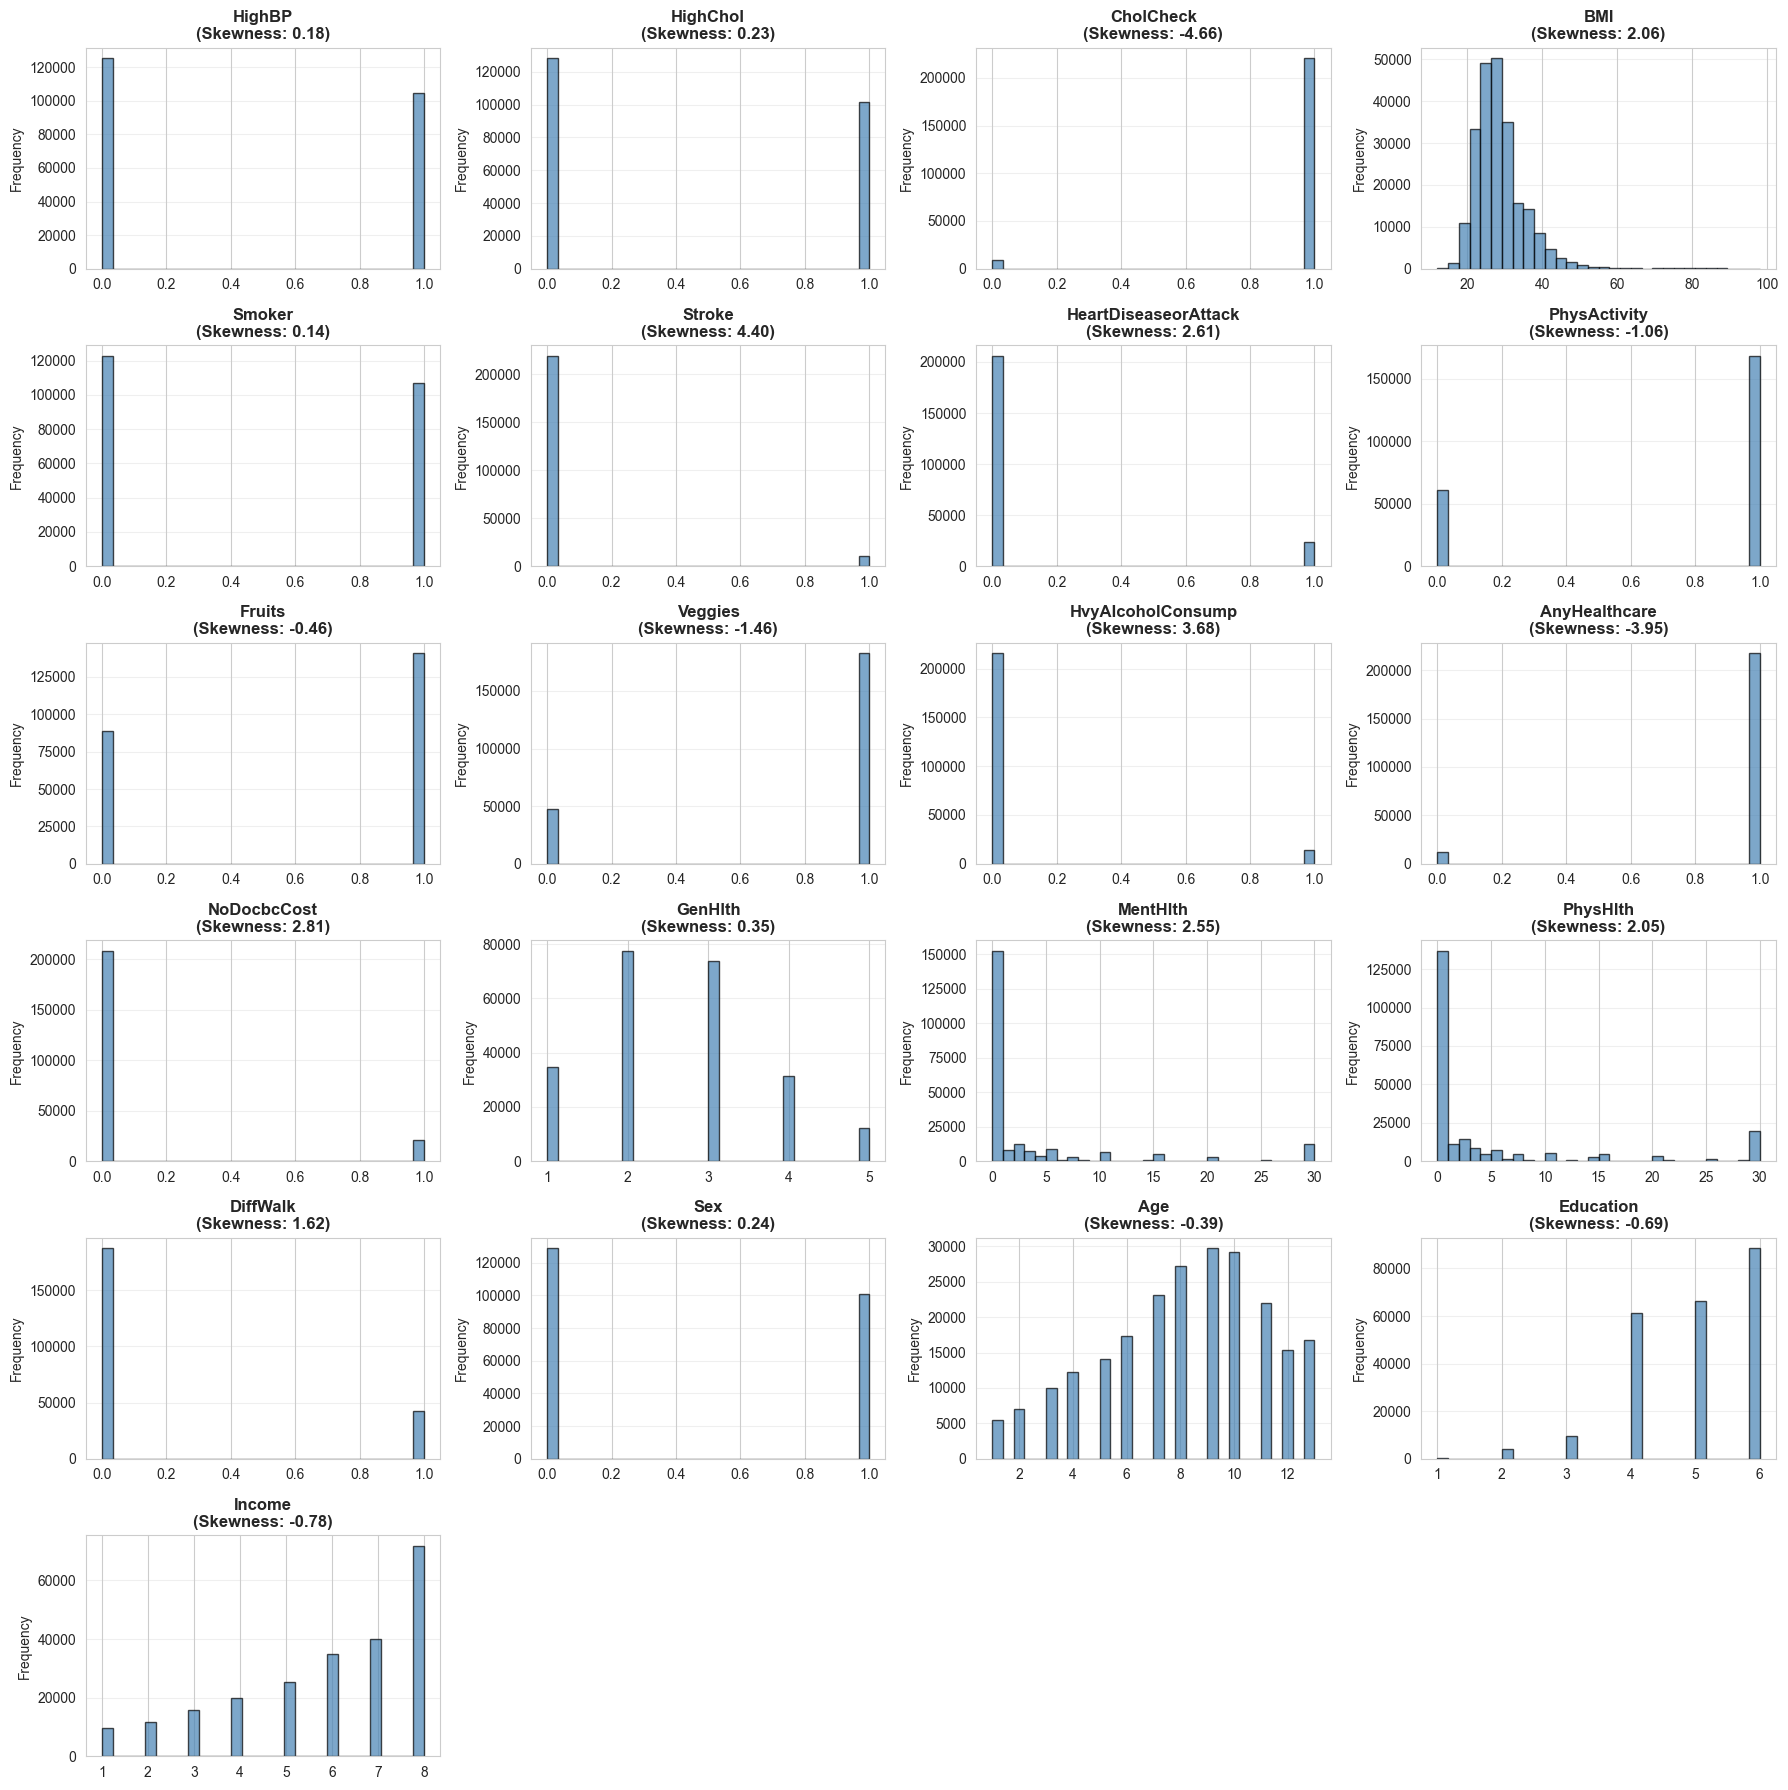

✓ Feature distributions plotted successfully



In [17]:
# 4. Visualize Feature Distributions
print("=" * 60)
print("4. FEATURE DISTRIBUTION VISUALIZATION")
print("=" * 60)

# Plot distributions of all features
n_features = len(X.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*3))
axes = axes.flatten()

for idx, col in enumerate(X.columns):
    axes[idx].hist(X[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}\n(Skewness: {stats.skew(X[col]):.2f})', fontweight='bold')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

# Hide empty subplots
for idx in range(len(X.columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Feature distributions plotted successfully")
print()

### 3.4 Correlation Analysis

Analyze relationships between features and the target variable:
- **Feature-Target Correlation**: Identify features most predictive of diabetes status
- **Feature-Feature Correlation**: Detect multicollinearity among predictors
- **Heatmap Visualization**: Visual representation of correlation matrix

**Note**: The bar chart shows top features by correlation strength, while the heatmap reveals all pairwise correlations.

5. CORRELATION ANALYSIS

Feature Correlation with Target (Diabetes_012):
  Diabetes_012: 1.0000
  GenHlth: 0.2849
  HighBP: 0.2620
  BMI: 0.2120
  DiffWalk: 0.2106
  HighChol: 0.2033
  Age: 0.1846
  HeartDiseaseorAttack: 0.1708
  PhysHlth: 0.1605
  Income: -0.1471
  Education: -0.1077
  PhysActivity: -0.1034
  Stroke: 0.1003
  CholCheck: 0.0757
  HvyAlcoholConsump: -0.0672
  MentHlth: 0.0577
  Smoker: 0.0468
  Veggies: -0.0434
  Sex: 0.0322
  Fruits: -0.0255
  AnyHealthcare: 0.0249


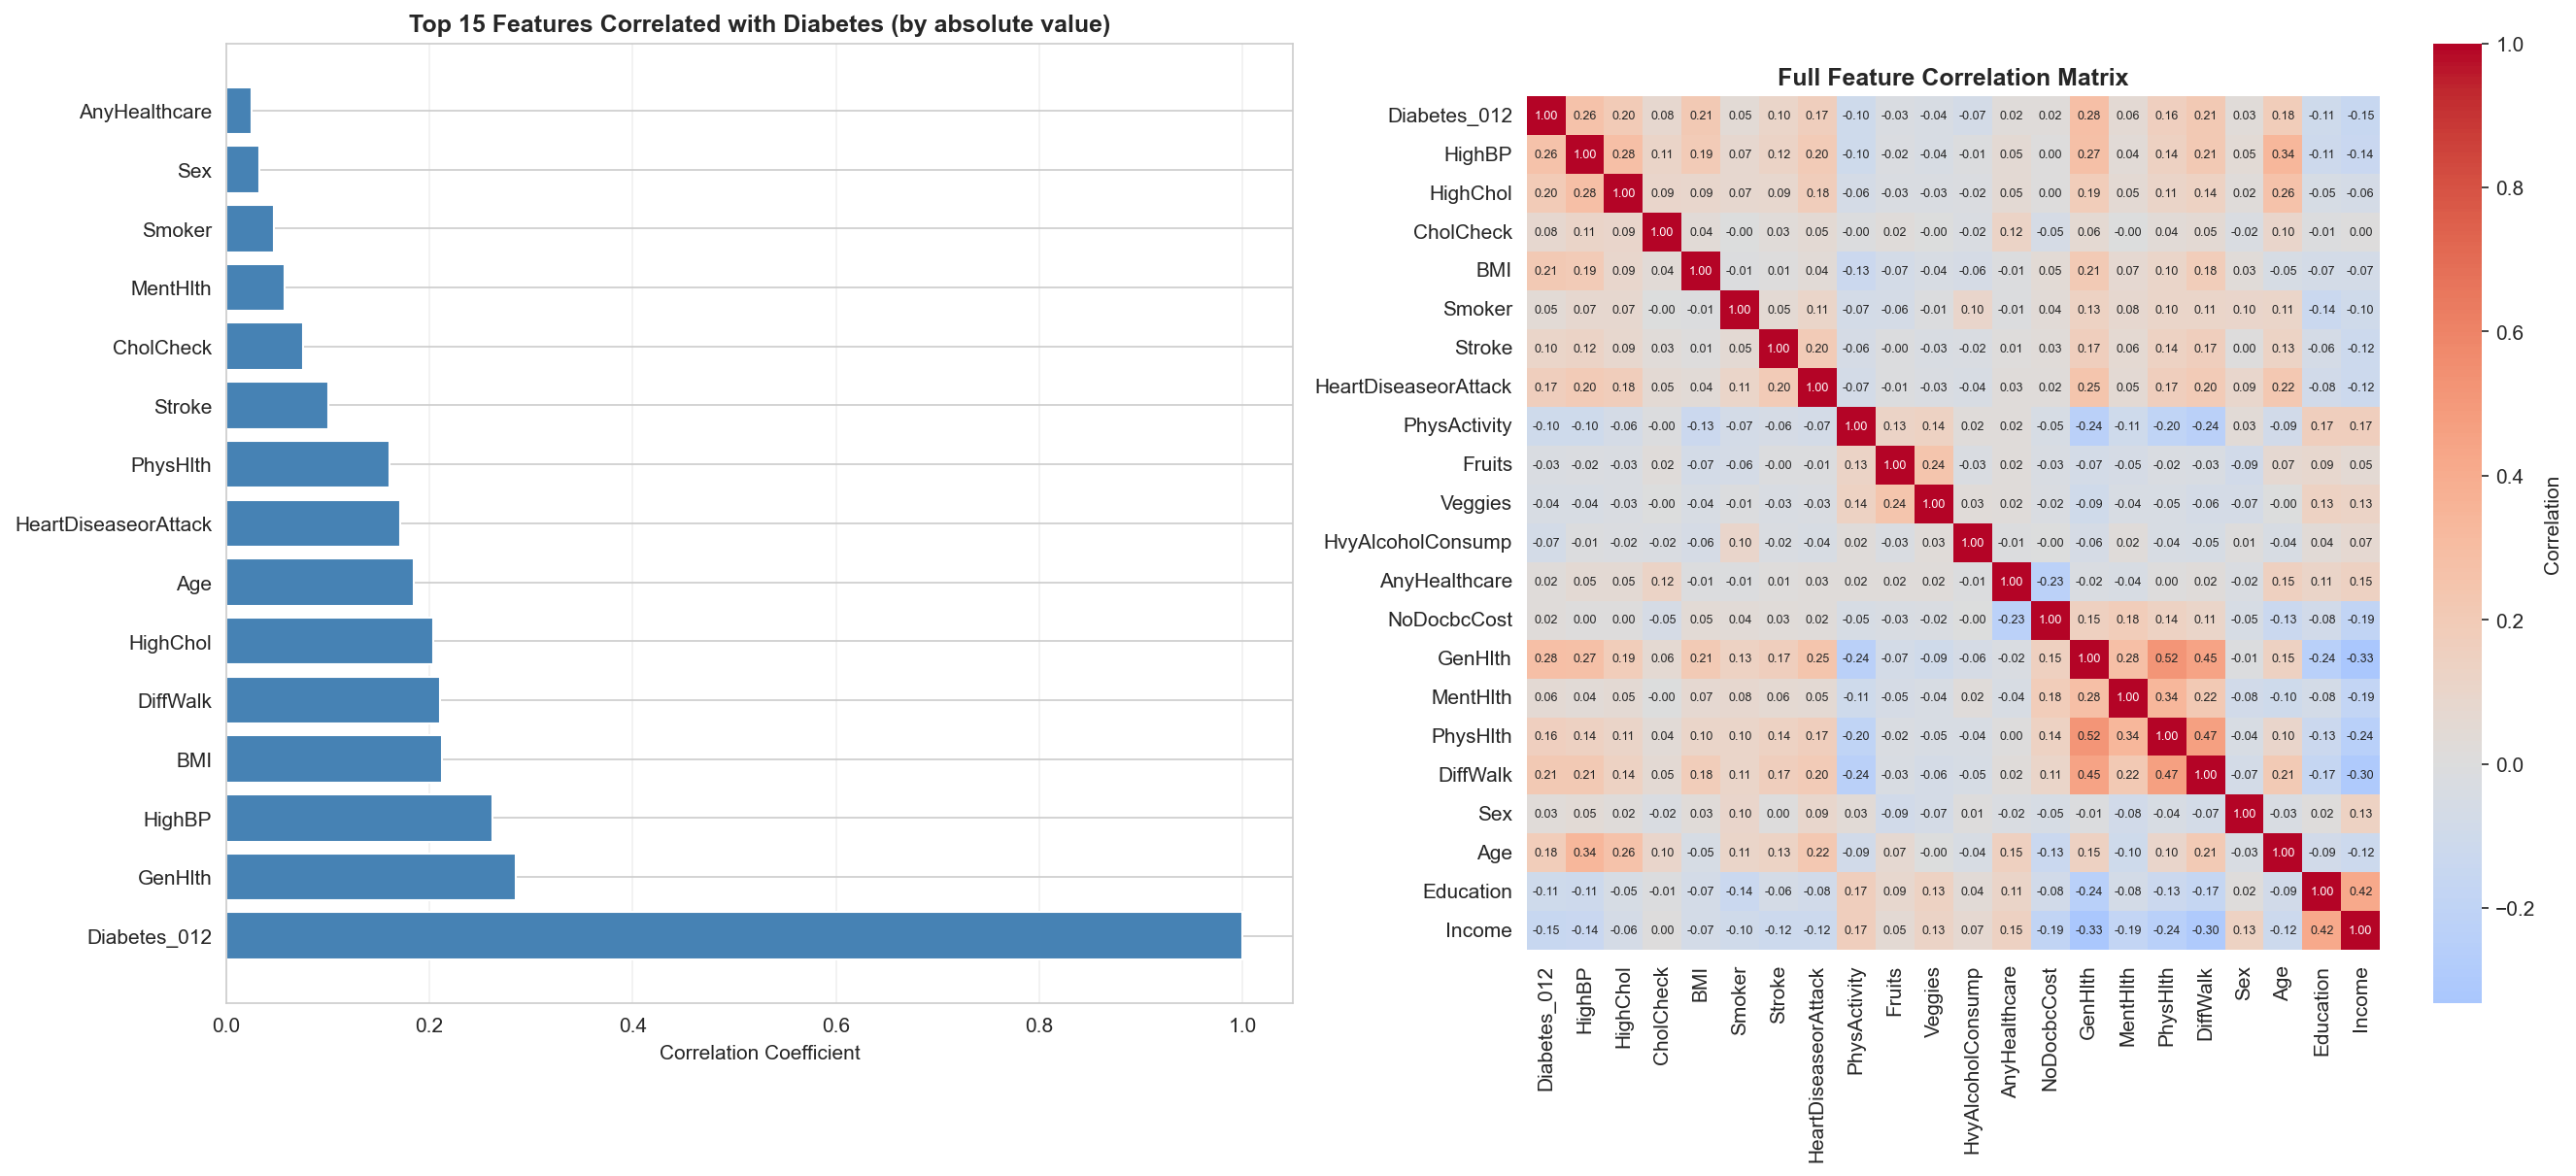


✓ Correlation analysis completed



In [18]:
# 5. Correlation Analysis
print("=" * 60)
print("5. CORRELATION ANALYSIS")
print("=" * 60)

# Compute correlation with target
correlation_with_target = X.join(y.rename("Diabetes_012")).corr()["Diabetes_012"].sort_values(key=abs, ascending=False)

print("\nFeature Correlation with Target (Diabetes_012):")
for feature, corr in correlation_with_target[:-1].items():  # exclude self-correlation
    print(f"  {feature}: {corr:.4f}")

# Full correlation matrix
corr_matrix = df.corr()

# Heatmap of correlations with target
fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=150)

# Top correlated features
top_corr = correlation_with_target[:-1].nlargest(15)
axes[0].barh(range(len(top_corr)), top_corr.values, color='steelblue')
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr.index)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('Top 15 Features Correlated with Diabetes (by absolute value)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Full correlation heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, ax=axes[1], cbar_kws={'label': 'Correlation'}, square=True,annot=True, fmt=".2f", annot_kws={"size": 6})
axes[1].set_title('Full Feature Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis completed")
print()

## Step 4: Data Preprocessing

Prepare data for machine learning:
1. **Train-Test Split**: Divide data into 80% training and 20% testing sets
   - Use `stratify=y` to maintain class distribution in both sets
   - Preserve class balance for reliable model evaluation
   
2. **Feature Scaling**: Apply StandardScaler to normalize features
   - Transform features to have mean=0 and std=1
   - Important for algorithms like Logistic Regression and distance-based methods
   - Random Forest and XGBoost handle scaling internally but we apply it anyway for consistency

In [19]:
# ============================================
# DATA PREPROCESSING
# ============================================
print("=" * 60)
print("6. DATA PREPROCESSING")
print("=" * 60)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Check class distribution in train and test sets
print("\nClass distribution in Training set:")
for idx, label in enumerate(['No Diabetes', 'Prediabetes', 'Diabetes']):
    count = (y_train == idx).sum()
    pct = (y_train == idx).sum() / len(y_train) * 100
    print(f"  Class {idx} ({label}): {count:,} ({pct:.2f}%)")

print("\nClass distribution in Testing set:")
for idx, label in enumerate(['No Diabetes', 'Prediabetes', 'Diabetes']):
    count = (y_test == idx).sum()
    pct = (y_test == idx).sum() / len(y_test) * 100
    print(f"  Class {idx} ({label}): {count:,} ({pct:.2f}%)")

# Scale only continuous features (non-binary)
continuous_features = [col for col in X_train.columns if X_train[col].nunique() > 2]

print("\nFeature scaling selection:")
print(f"  Continuous features (scaled): {len(continuous_features)}")
if continuous_features:
    print(f"    {continuous_features}")

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if continuous_features:
    scaler = StandardScaler()
    X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
    X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])
    print("\n✓ Continuous features standardized using StandardScaler")
else:
    print("\n✓ No continuous features found to scale")

print("✓ Non-continuous features remain unchanged")
print("✓ Data preprocessing completed")
print()

6. DATA PREPROCESSING

Training set shape: (183824, 21)
Testing set shape: (45957, 21)

Class distribution in Training set:
  Class 0 (No Diabetes): 152,043 (82.71%)
  Class 1 (Prediabetes): 3,703 (2.01%)
  Class 2 (Diabetes): 28,078 (15.27%)

Class distribution in Testing set:
  Class 0 (No Diabetes): 38,012 (82.71%)
  Class 1 (Prediabetes): 926 (2.01%)
  Class 2 (Diabetes): 7,019 (15.27%)

Feature scaling selection:
  Continuous features (scaled): 7
    ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

✓ Continuous features standardized using StandardScaler
✓ Non-continuous features remain unchanged
✓ Data preprocessing completed



In [20]:
# Apply log1p to highly skewed non-binary features, then rescale
skewed_features = skewness_df.loc[
    (skewness_df['Feature'].isin(continuous_features)) &
    (skewness_df['Skewness'].abs() > 1),
    'Feature'
].tolist()

X_train_log = X_train.copy()
X_test_log = X_test.copy()

if skewed_features:
    X_train_log[skewed_features] = np.log1p(X_train_log[skewed_features])
    X_test_log[skewed_features] = np.log1p(X_test_log[skewed_features])

    scaler_log = StandardScaler()
    X_train_scaled_log = X_train_log.copy()
    X_test_scaled_log = X_test_log.copy()
    X_train_scaled_log[continuous_features] = scaler_log.fit_transform(X_train_log[continuous_features])
    X_test_scaled_log[continuous_features] = scaler_log.transform(X_test_log[continuous_features])

    print(f"Applied log1p to: {skewed_features}")
else:
    X_train_scaled_log = X_train_scaled.copy()
    X_test_scaled_log = X_test_scaled.copy()
    print("No highly skewed non-binary features found.")

Applied log1p to: ['MentHlth', 'BMI', 'PhysHlth']


## Step 5: Building Classification Models

Train three different machine learning models to compare their performance:

### 5.1 Model Choices

1. **Logistic Regression**
   - Linear classification algorithm
   - Outputs probability scores for each class
   - Interpretable coefficients indicate feature importance
   - Sensitive to feature scaling (hence preprocessing is important)

2. **Random Forest Classifier**
   - Ensemble of decision trees
   - Handles non-linear relationships well
   - Built-in feature importance from split calculations
   - Less sensitive to feature scaling
   - Can capture complex patterns in data

3. **XGBoost Classifier**
   - Gradient boosting ensemble method
   - Iteratively trains trees to correct previous errors
   - Often achieves state-of-the-art performance
   - Best for structured/tabular data
   - Built-in regularization to prevent overfitting

In [21]:
# ============================================
# MODEL BUILDING & TRAINING
# ============================================
print("=" * 60)
print("7. BUILDING CLASSIFICATION MODELS")
print("=" * 60)

# Dictionary to store models and their predictions
models = {}
predictions = {}

# 7.1 Logistic Regression
print("\n7.1 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)
models['Logistic Regression'] = lr_model
predictions['Logistic Regression'] = y_pred_lr
print("✓ Logistic Regression trained successfully")

# 7.2 Random Forest
print("\n7.2 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, 
                                  random_state=42, n_jobs=-1, 
                                  class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)
models['Random Forest'] = rf_model
predictions['Random Forest'] = y_pred_rf
print("✓ Random Forest trained successfully")

# 7.3 XGBoost
print("\n7.3 Training XGBoost...")
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                          random_state=42, n_jobs=-1, scale_pos_weight=2,
                          eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = y_pred_xgb
print("✓ XGBoost trained successfully")

print("\n✓ All models trained successfully!")
print()

7. BUILDING CLASSIFICATION MODELS

7.1 Training Logistic Regression...
✓ Logistic Regression trained successfully

7.2 Training Random Forest...
✓ Random Forest trained successfully

7.3 Training XGBoost...
✓ XGBoost trained successfully

✓ All models trained successfully!



## Step 6: Model Evaluation & Performance Metrics

Evaluate models using multiple metrics:

### 6.1 Evaluation Metrics Explained

- **Accuracy**: Percentage of correct predictions (but misleading with imbalanced data)
- **Balanced Accuracy**: Mean of recall for each class (better for imbalanced datasets)
- **Precision**: Of predicted positives, how many are actually positive? (Minimize false positives)
- **Recall**: Of actual positives, how many did we find? (Minimize false negatives) - **MOST IMPORTANT FOR DIABETES**
- **F1-Score**: Harmonic mean of precision and recall (balance both metrics)
- **Confusion Matrix**: Shows true positives, false positives, true negatives, false negatives
- **Classification Report**: Combined metrics for all classes

### 6.2 Why These Metrics Matter for Healthcare

In diabetes prediction:
- **High Recall is Critical**: Missing a diabetes case (false negative) has serious health consequences
- **High Precision is Secondary**: False alarms lead to follow-up testing but not immediate harm
- **Trade-off**: We may sacrifice overall accuracy for better disease detection

In [22]:
# ============================================
# MODEL EVALUATION
# ============================================
print("=" * 60)
print("8. MODEL EVALUATION & PERFORMANCE METRICS")
print("=" * 60)

# Dictionary to store evaluation metrics
all_metrics = {}

# Evaluate each model
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
y_preds = [y_pred_lr, y_pred_rf, y_pred_xgb]
y_pred_probas = [y_pred_lr_proba, y_pred_rf_proba, y_pred_xgb_proba]

for model_name, y_pred, y_pred_proba in zip(model_names, y_preds, y_pred_probas):
    print(f"\n{'='*60}")
    print(f"{model_name.upper()}")
    print(f"{'='*60}")
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"\nAccuracy Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:")
    print(cm)
    
    # Store metrics
    all_metrics[model_name] = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc,
        'Confusion Matrix': cm,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }

print("\n✓ Model evaluation completed")
print()

8. MODEL EVALUATION & PERFORMANCE METRICS

LOGISTIC REGRESSION

Accuracy Metrics:
  Accuracy: 0.8330
  Balanced Accuracy: 0.3826

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.85      0.98      0.91     38012
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.54      0.17      0.26      7019

    accuracy                           0.83     45957
   macro avg       0.46      0.38      0.39     45957
weighted avg       0.78      0.83      0.79     45957

Confusion Matrix:
[[37071     0   941]
 [  847     0    79]
 [ 5808     0  1211]]

RANDOM FOREST

Accuracy Metrics:
  Accuracy: 0.7427
  Balanced Accuracy: 0.4879

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.92      0.78      0.84     38012
 Prediabetes       0.03      0.04      0.04       926
    Diabetes       0.36      0.64      0.46      7019

    accuracy                           0.74     45957
   macr

## Step 7: Confusion Matrices Visualization

Visualize model predictions in detail using confusion matrices:
- **Diagonal (✓)**: Correct predictions
- **Off-diagonal (✗)**: Misclassifications
- **3×3 Matrix**: Three classes (No Diabetes, Prediabetes, Diabetes)

Helps identify which classes are being confused with each other.

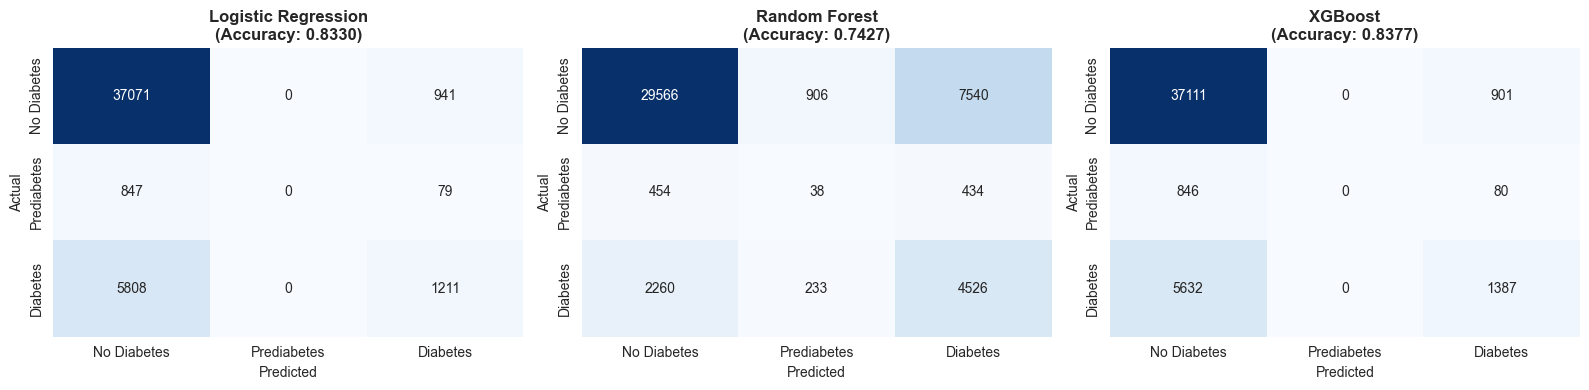

✓ Confusion matrices plotted



In [23]:
# Visualize Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, model_name in enumerate(model_names):
    cm = all_metrics[model_name]['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
    axes[idx].set_title(f'{model_name}\n(Accuracy: {all_metrics[model_name]["Accuracy"]:.4f})', 
                       fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("✓ Confusion matrices plotted")
print()

## Step 8: Model Comparison

Compare performance of all three models across different metrics:
- **Accuracy**: Overall prediction correctness
- **Balanced Accuracy**: Fair metric for imbalanced data
- **Side-by-side Comparison**: Visualize strengths and weaknesses
- **Identify Best Model**: Choose model based on business requirements

For diabetes prediction, we prioritize models with **high recall** over high accuracy.

9. MODEL COMPARISON

              Model  Accuracy  Balanced Accuracy
            XGBoost  0.837696           0.391301
Logistic Regression  0.832996           0.382592
      Random Forest  0.742651           0.487888


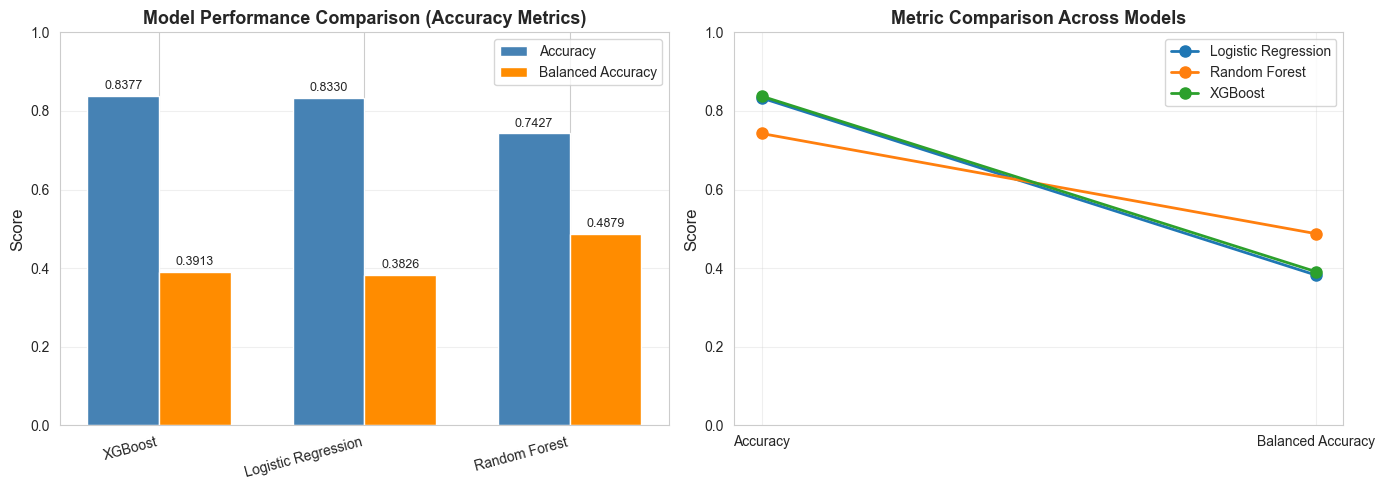


✓ Model comparison completed



In [24]:
# Model Comparison
print("=" * 60)
print("9. MODEL COMPARISON")
print("=" * 60)

comparison_data = []
for model_name in model_names:
    comparison_data.append({
        'Model': model_name,
        'Accuracy': all_metrics[model_name]['Accuracy'],
        'Balanced Accuracy': all_metrics[model_name]['Balanced Accuracy']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Accuracy', ascending=False)
print("\n" + comparison_df.to_string(index=False))

# Visualize Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models_list = comparison_df['Model'].tolist()
accuracies = comparison_df['Accuracy'].tolist()
balanced_accs = comparison_df['Balanced Accuracy'].tolist()

x_pos = np.arange(len(models_list))
width = 0.35

axes[0].bar(x_pos - width/2, accuracies, width, label='Accuracy', color='steelblue')
axes[0].bar(x_pos + width/2, balanced_accs, width, label='Balanced Accuracy', color='darkorange')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison (Accuracy Metrics)', fontweight='bold', fontsize=13)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_list, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Add value labels on bars
for i, (acc, bal_acc) in enumerate(zip(accuracies, balanced_accs)):
    axes[0].text(i - width/2, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, bal_acc + 0.01, f'{bal_acc:.4f}', ha='center', va='bottom', fontsize=9)

# Line plot of metrics
for model_name in model_names:
    metrics = all_metrics[model_name]
    axes[1].plot([0, 1], [metrics['Accuracy'], metrics['Balanced Accuracy']], 
                marker='o', label=model_name, linewidth=2, markersize=8)

axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Accuracy', 'Balanced Accuracy'])
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Metric Comparison Across Models', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Model comparison completed")
print()

## Step 9: Feature Importance Analysis

Identify which features are most important for predictions:

### 9.1 Feature Importance Methods

**Random Forest**:
- Calculates importance based on how much each feature decreases impurity across all trees
- Higher values = more important for splitting decisions

**XGBoost**:
- Uses gain-based importance (average improvement brought by feature)
- More robust than impurity-based methods for gradient boosting

### 9.2 Insights

- Top features indicate strongest predictors of diabetes
- Can guide clinical focus and data collection efforts
- Helps explain model predictions

10. FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 15 Important Features:
     Feature  Importance
         BMI    0.152898
         Age    0.128608
     GenHlth    0.093197
      Income    0.080506
    PhysHlth    0.075160
    MentHlth    0.067398
      HighBP    0.062978
   Education    0.057753
    HighChol    0.040362
      Smoker    0.028190
         Sex    0.027982
      Fruits    0.027763
PhysActivity    0.025065
    DiffWalk    0.024762
     Veggies    0.024410


XGBoost - Top 15 Important Features:
             Feature  Importance
              HighBP    0.504832
             GenHlth    0.122737
            HighChol    0.076296
           CholCheck    0.039202
   HvyAlcoholConsump    0.037648
                 Age    0.032712
                 BMI    0.028420
HeartDiseaseorAttack    0.023095
            DiffWalk    0.021286
                 Sex    0.018118
              Income    0.011594
              Stroke    0.010945
       AnyHealthcare    0.008644
            MentHlth   

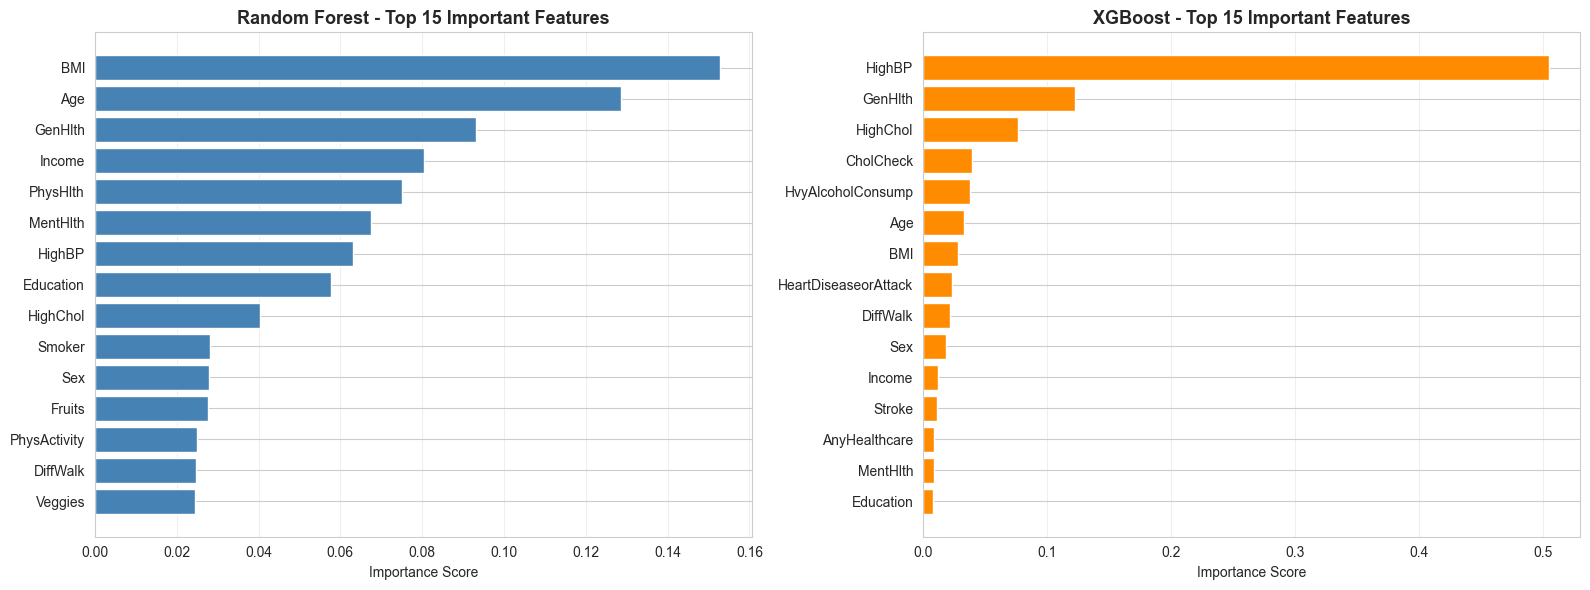


✓ Feature importance analysis completed



In [25]:
# Feature Importance
print("=" * 60)
print("10. FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Random Forest Feature Importance
print("\nRandom Forest - Top 15 Important Features:")
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(rf_importance.head(15).to_string(index=False))

# XGBoost Feature Importance
print("\n\nXGBoost - Top 15 Important Features:")
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(xgb_importance.head(15).to_string(index=False))

# Visualize Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
rf_top = rf_importance.head(15)
axes[0].barh(range(len(rf_top)), rf_top['Importance'].values, color='steelblue')
axes[0].set_yticks(range(len(rf_top)))
axes[0].set_yticklabels(rf_top['Feature'].values)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest - Top 15 Important Features', fontweight='bold', fontsize=13)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# XGBoost
xgb_top = xgb_importance.head(15)
axes[1].barh(range(len(xgb_top)), xgb_top['Importance'].values, color='darkorange')
axes[1].set_yticks(range(len(xgb_top)))
axes[1].set_yticklabels(xgb_top['Feature'].values)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('XGBoost - Top 15 Important Features', fontweight='bold', fontsize=13)
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis completed")
print()

## Step 10: Cross-Validation Analysis

Validate model performance using 5-Fold Cross-Validation:

### 10.1 What is Cross-Validation?

**5-Fold CV Process**:
1. Divide training data into 5 equal folds
2. For each iteration:
   - Use 4 folds for training
   - Use 1 fold for testing
3. Average results across all 5 iterations
4. Calculate standard deviation to measure consistency

### 10.2 Benefits

- **More Reliable**: Uses all data for both training and testing
- **Robustness Check**: Validates that performance isn't due to lucky train-test split
- **Stability**: Low std dev = stable, consistent model

**Interpretation**: 5 CV scores show how model performs on different data subsets, confirming generalization ability.

11. CROSS-VALIDATION ANALYSIS

Performing 5-Fold Cross-Validation...

Logistic Regression:
  CV Scores: [0.83185095 0.83049096 0.83147015 0.83008296 0.83225438]
  Mean CV Score: 0.8312 (+/- 0.0008)

Random Forest:
  CV Scores: [0.74165647 0.74448524 0.74625323 0.74448524 0.74548471]
  Mean CV Score: 0.7445 (+/- 0.0016)

XGBoost:
  CV Scores: [0.83310214 0.83438052 0.83571331 0.83307494 0.83502883]
  Mean CV Score: 0.8343 (+/- 0.0010)


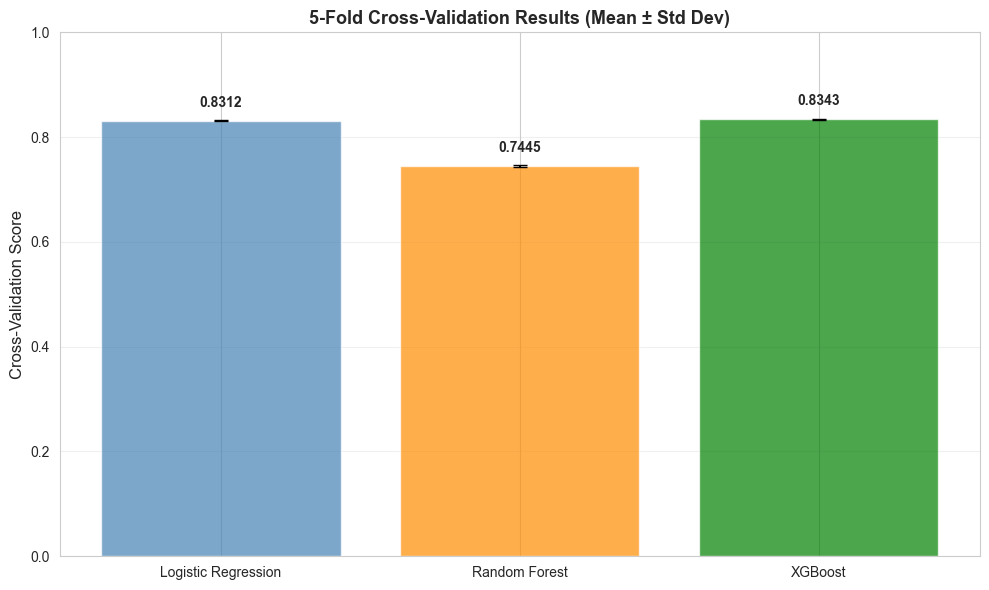


✓ Cross-validation analysis completed



In [26]:
# Cross-Validation
print("=" * 60)
print("11. CROSS-VALIDATION ANALYSIS")
print("=" * 60)

cv_results = {}

print("\nPerforming 5-Fold Cross-Validation...\n")

# Logistic Regression CV
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_results['Logistic Regression'] = lr_cv_scores
print(f"Logistic Regression:")
print(f"  CV Scores: {lr_cv_scores}")
print(f"  Mean CV Score: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std():.4f})")

# Random Forest CV
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
cv_results['Random Forest'] = rf_cv_scores
print(f"\nRandom Forest:")
print(f"  CV Scores: {rf_cv_scores}")
print(f"  Mean CV Score: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

# XGBoost CV
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
cv_results['XGBoost'] = xgb_cv_scores
print(f"\nXGBoost:")
print(f"  CV Scores: {xgb_cv_scores}")
print(f"  Mean CV Score: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std():.4f})")

# Visualize Cross-Validation Results
fig, ax = plt.subplots(figsize=(10, 6))

cv_data = []
for model_name, scores in cv_results.items():
    cv_data.append({
        'Model': model_name,
        'Mean CV Score': scores.mean(),
        'Std Dev': scores.std()
    })

cv_df = pd.DataFrame(cv_data)

x_pos = np.arange(len(cv_df))
ax.bar(x_pos, cv_df['Mean CV Score'], yerr=cv_df['Std Dev'], 
       capsize=5, alpha=0.7, color=['steelblue', 'darkorange', 'green'])
ax.set_ylabel('Cross-Validation Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results (Mean ± Std Dev)', fontweight='bold', fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(cv_df['Model'])
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (mean, std) in enumerate(zip(cv_df['Mean CV Score'], cv_df['Std Dev'])):
    ax.text(i, mean + std + 0.02, f'{mean:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Cross-validation analysis completed")
print()

ROC-AUC ANALYSIS FOR THREE MODELS

1. ROC-AUC SCORES (One-vs-Rest):
------------------------------------------------------------

Logistic Regression:
  Weighted ROC-AUC: 0.8066
  Class 0 (No Diabetes): 0.8083
  Class 1 (Prediabetes): 0.6864
  Class 2 (Diabetes): 0.8136

Random Forest:
  Weighted ROC-AUC: 0.7938
  Class 0 (No Diabetes): 0.7946
  Class 1 (Prediabetes): 0.6089
  Class 2 (Diabetes): 0.8136

XGBoost:
  Weighted ROC-AUC: 0.8132
  Class 0 (No Diabetes): 0.8150
  Class 1 (Prediabetes): 0.6792
  Class 2 (Diabetes): 0.8209


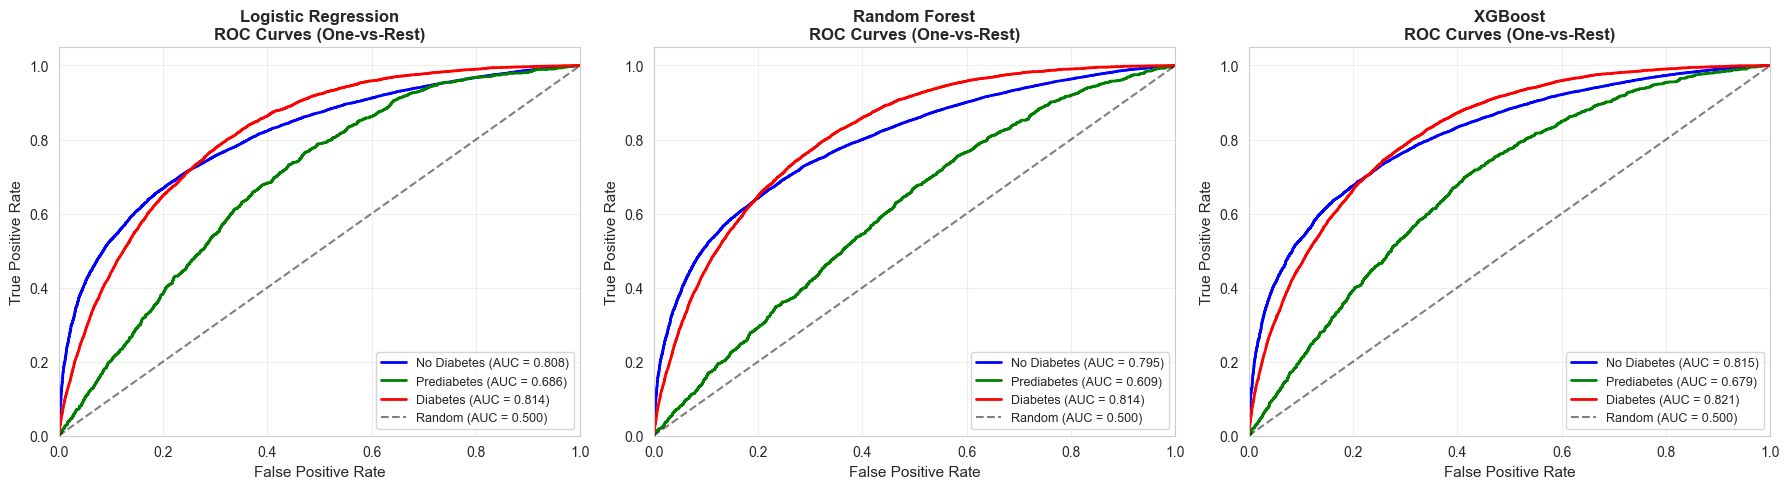


2. ROC-AUC COMPARISON SUMMARY:

              Model  Weighted ROC-AUC
            XGBoost          0.813177
Logistic Regression          0.806633
      Random Forest          0.793761

🏆 Best Model by ROC-AUC: XGBoost
   Score: 0.8132

✓ ROC-AUC analysis completed


In [28]:
from sklearn.preprocessing import label_binarize

# ============================================
# ROC-AUC Analysis for Multi-class Classification
# ============================================
print("=" * 60)
print("ROC-AUC ANALYSIS FOR THREE MODELS")
print("=" * 60)


# Binarize the labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

# Calculate ROC-AUC for each model
print("\n1. ROC-AUC SCORES (One-vs-Rest):")
print("-" * 60)

# Logistic Regression
lr_roc_auc = roc_auc_score(y_test_binarized, y_pred_lr_proba, 
                           multi_class='ovr', average='weighted')
print(f"\nLogistic Regression:")
print(f"  Weighted ROC-AUC: {lr_roc_auc:.4f}")

# Per-class ROC-AUC
for i, class_name in enumerate(['No Diabetes', 'Prediabetes', 'Diabetes']):
    class_roc_auc = roc_auc_score(y_test_binarized[:, i], y_pred_lr_proba[:, i])
    print(f"  Class {i} ({class_name}): {class_roc_auc:.4f}")

# Random Forest
rf_roc_auc = roc_auc_score(y_test_binarized, y_pred_rf_proba, 
                          multi_class='ovr', average='weighted')
print(f"\nRandom Forest:")
print(f"  Weighted ROC-AUC: {rf_roc_auc:.4f}")

# Per-class ROC-AUC
for i, class_name in enumerate(['No Diabetes', 'Prediabetes', 'Diabetes']):
    class_roc_auc = roc_auc_score(y_test_binarized[:, i], y_pred_rf_proba[:, i])
    print(f"  Class {i} ({class_name}): {class_roc_auc:.4f}")

# XGBoost
xgb_roc_auc = roc_auc_score(y_test_binarized, y_pred_xgb_proba, 
                           multi_class='ovr', average='weighted')
print(f"\nXGBoost:")
print(f"  Weighted ROC-AUC: {xgb_roc_auc:.4f}")

# Per-class ROC-AUC
for i, class_name in enumerate(['No Diabetes', 'Prediabetes', 'Diabetes']):
    class_roc_auc = roc_auc_score(y_test_binarized[:, i], y_pred_xgb_proba[:, i])
    print(f"  Class {i} ({class_name}): {class_roc_auc:.4f}")

# Visualize ROC Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_probas = [y_pred_lr_proba, y_pred_rf_proba, y_pred_xgb_proba]
model_titles = ['Logistic Regression', 'Random Forest', 'XGBoost']
colors = ['blue', 'green', 'red']
class_names = ['No Diabetes', 'Prediabetes', 'Diabetes']

for idx, (model_proba, model_title) in enumerate(zip(model_probas, model_titles)):
    ax = axes[idx]
    
    # Plot ROC curve for each class
    for i, (color, class_name) in enumerate(zip(colors, class_names)):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], model_proba[:, i])
        roc_auc = roc_auc_score(y_test_binarized[:, i], model_proba[:, i])
        
        ax.plot(fpr, tpr, color=color, lw=2, 
               label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random (AUC = 0.500)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{model_title}\nROC Curves (One-vs-Rest)', fontweight='bold', fontsize=12)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "=" * 60)
print("2. ROC-AUC COMPARISON SUMMARY:")
print("=" * 60)

roc_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Weighted ROC-AUC': [lr_roc_auc, rf_roc_auc, xgb_roc_auc]
}).sort_values('Weighted ROC-AUC', ascending=False)

print("\n" + roc_comparison.to_string(index=False))

print(f"\n🏆 Best Model by ROC-AUC: {roc_comparison.iloc[0]['Model']}")
print(f"   Score: {roc_comparison.iloc[0]['Weighted ROC-AUC']:.4f}")

print("\n✓ ROC-AUC analysis completed")

## Step 11: Summary of Initial Analysis

Consolidate findings from the EDA and baseline models:
- Dataset characteristics and class imbalance identified
- Feature statistics and correlations analyzed
- Three baseline models trained and evaluated
- Performance metrics recorded for comparison
- Feature importance rankings established
- Model generalization validated via cross-validation

In [29]:
# Summary and Conclusions
print("=" * 80)
print("SUMMARY AND CONCLUSIONS".center(80))
print("=" * 80)

print("\n📊 DATASET OVERVIEW:")
print(f"  • Total records: {len(df):,}")
print(f"  • Total features: {len(X.columns)}")
print(f"  • Target variable: Diabetes_012")
print(f"  • Class distribution: Highly imbalanced")
print(f"    - No Diabetes: {(y == 0).sum():,} ({(y == 0).sum()/len(y)*100:.1f}%)")
print(f"    - Prediabetes: {(y == 1).sum():,} ({(y == 1).sum()/len(y)*100:.1f}%)")
print(f"    - Diabetes: {(y == 2).sum():,} ({(y == 2).sum()/len(y)*100:.1f}%)")

print("\n📈 KEY FINDINGS FROM EDA:")
print(f"  • No missing values in the dataset")
print(f"  • Features with highest skewness: {skewness_df.head(3)['Feature'].tolist()}")
print(f"  • Most important predictive features:")
for i, (feature, importance) in enumerate(rf_importance.head(3).values, 1):
    print(f"    {i}. {feature}")

print("\n🤖 MODEL PERFORMANCE SUMMARY:")
for model_name in model_names:
    acc = all_metrics[model_name]['Accuracy']
    bal_acc = all_metrics[model_name]['Balanced Accuracy']
    cv_mean = cv_results[model_name].mean()
    print(f"\n  {model_name}:")
    print(f"    • Test Accuracy: {acc:.4f}")
    print(f"    • Balanced Accuracy: {bal_acc:.4f}")
    print(f"    • Cross-Validation Score (5-Fold): {cv_mean:.4f}")

print("\n🏆 BEST PERFORMING MODEL:")
best_model = comparison_df.iloc[0]
print(f"  • Model: {best_model['Model']}")
print(f"  • Test Accuracy: {best_model['Accuracy']:.4f}")
print(f"  • Balanced Accuracy: {best_model['Balanced Accuracy']:.4f}")

print("\n⚠️ IMPORTANT NOTES:")
print(f"  • The dataset shows significant class imbalance")
print(f"  • Balanced Accuracy is more important than regular Accuracy for imbalanced data")
print(f"  • Feature scaling was applied for Logistic Regression")
print(f"  • Random Forest and XGBoost naturally handle feature scaling")
print(f"  • All models were trained on 80% of data and tested on 20%")

print("\n" + "=" * 80)
print("✓ ANALYSIS COMPLETE!".center(80))
print("=" * 80)

                            SUMMARY AND CONCLUSIONS                             

📊 DATASET OVERVIEW:
  • Total records: 229,781
  • Total features: 21
  • Target variable: Diabetes_012
  • Class distribution: Highly imbalanced
    - No Diabetes: 190,055 (82.7%)
    - Prediabetes: 4,629 (2.0%)
    - Diabetes: 35,097 (15.3%)

📈 KEY FINDINGS FROM EDA:
  • No missing values in the dataset
  • Features with highest skewness: ['CholCheck', 'Stroke', 'AnyHealthcare']
  • Most important predictive features:
    1. BMI
    2. Age
    3. GenHlth

🤖 MODEL PERFORMANCE SUMMARY:

  Logistic Regression:
    • Test Accuracy: 0.8330
    • Balanced Accuracy: 0.3826
    • Cross-Validation Score (5-Fold): 0.8312

  Random Forest:
    • Test Accuracy: 0.7427
    • Balanced Accuracy: 0.4879
    • Cross-Validation Score (5-Fold): 0.7445

  XGBoost:
    • Test Accuracy: 0.8377
    • Balanced Accuracy: 0.3913
    • Cross-Validation Score (5-Fold): 0.8343

🏆 BEST PERFORMING MODEL:
  • Model: XGBoost
  • Test A

---

# Part 2: Improving Model Performance - Addressing Class Imbalance

## 🔍 Problem Identified

The baseline models suffer from **severe class imbalance**:
- Original diabetes recall: 17-65% (models miss 35-83% of diabetes cases!)
- Original prediabetes recall: 0-3% (essentially failing to detect prediabetes)
- Reason: Models biased toward predicting "No Diabetes" to maximize accuracy

## 🎯 Solution Strategy

Three complementary approaches to improve recall:

### Strategy 1: **Class Weight Balancing**
- Penalize misclassification of minority classes more heavily
- Parameters: `class_weight='balanced'`
- Pros: Simple, built into most algorithms, fast
- Cons: Heuristic approach, may not be optimal

### Strategy 2: **SMOTE (Synthetic Minority Oversampling)**
- Generate synthetic samples for minority classes
- Creates artificially balanced training dataset
- Pros: Data-driven approach, validated technique
- Cons: More computation, potential for overfitting on synthetic data

### Strategy 3: **Hyperparameter Tuning**
- Optimize model parameters specifically for balanced accuracy
- Use GridSearchCV to find best configuration
- Pros: Production-ready, comprehensive search
- Cons: Computationally expensive, time-consuming

In [31]:
# ============================================
# IMPROVED MODELS - ADDRESSING CLASS IMBALANCE
# ============================================
print("=" * 60)
print("IMPROVED MODELS - CLASS IMBALANCE SOLUTIONS")
print("=" * 60)

print("\n🔧 STRATEGY 1: Class Weight Balancing")
print("=" * 60)

# 1. Logistic Regression with balanced class weights
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_balanced.fit(X_train_scaled, y_train)
y_pred_lr_bal = lr_balanced.predict(X_test_scaled)

print("\nLogistic Regression (Balanced Class Weights):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_lr_bal):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_lr_bal):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_bal, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

# 2. Random Forest with balanced class weights
rf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_balanced.fit(X_train_scaled, y_train)
y_pred_rf_bal = rf_balanced.predict(X_test_scaled)

print("\n" + "=" * 60)
print("\nRandom Forest (Balanced Class Weights):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_bal):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_rf_bal):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_bal, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

# 3. XGBoost with scale_pos_weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights for XGBoost
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = np.array([class_weights[int(i)] for i in y_train])

xgb_balanced = XGBClassifier(random_state=42, n_jobs=-1)
xgb_balanced.fit(X_train_scaled, y_train, sample_weight=sample_weights)
y_pred_xgb_bal = xgb_balanced.predict(X_test_scaled)

print("\n" + "=" * 60)
print("\nXGBoost (Sample Weighting):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb_bal):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_xgb_bal):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_bal, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

print("\n✓ Strategy 1 completed")


IMPROVED MODELS - CLASS IMBALANCE SOLUTIONS

🔧 STRATEGY 1: Class Weight Balancing

Logistic Regression (Balanced Class Weights):
  Accuracy: 0.6293
  Balanced Accuracy: 0.5135

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.94      0.64      0.77     38012
 Prediabetes       0.03      0.30      0.06       926
    Diabetes       0.37      0.59      0.45      7019

    accuracy                           0.63     45957
   macro avg       0.45      0.51      0.43     45957
weighted avg       0.84      0.63      0.70     45957



Random Forest (Balanced Class Weights):
  Accuracy: 0.8231
  Balanced Accuracy: 0.3734

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.84      0.97      0.90     38012
 Prediabetes       0.01      0.00      0.00       926
    Diabetes       0.45      0.15      0.23      7019

    accuracy                           0.82     45957
   macro avg       0.44      0.37 

## Implementation 1: Class Weight Balancing

### How It Works

- Calculate weights inversely proportional to class frequencies
- Weight formula: w_i = n_samples / (n_classes × n_samples_i)
- During training, errors on minority classes are penalized more heavily
- Common parameter: `class_weight='balanced'`

### Models Implemented

- **Logistic Regression**: Uses `class_weight='balanced'`
- **Random Forest**: Uses `class_weight='balanced'` or `'balanced_subsample'`
- **XGBoost**: Uses sample weights calculated from class frequencies

### Expected Results

- Significant recall improvement for minority classes (diabetes, prediabetes)
- Trade-off: Lower overall accuracy but better disease detection
- Balanced accuracy should improve substantially

In [30]:
# ============================================
# STRATEGY 2: SMOTE (Synthetic Oversampling)
# ============================================
print("\n🔧 STRATEGY 2: SMOTE - Synthetic Minority Oversampling")
print("=" * 60)

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal training set distribution:")
print(f"  Class 0 (No Diabetes): {(y_train == 0).sum():,}")
print(f"  Class 1 (Prediabetes): {(y_train == 1).sum():,}")
print(f"  Class 2 (Diabetes): {(y_train == 2).sum():,}")

print(f"\nAfter SMOTE:")
print(f"  Class 0 (No Diabetes): {(y_train_smote == 0).sum():,}")
print(f"  Class 1 (Prediabetes): {(y_train_smote == 1).sum():,}")
print(f"  Class 2 (Diabetes): {(y_train_smote == 2).sum():,}")

# Train models on SMOTE-balanced data
print("\n" + "-" * 60)
print("Training models on SMOTE-balanced data...")

# Logistic Regression with SMOTE
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_lr_smote = lr_smote.predict(X_test_scaled)

print("\nLogistic Regression (SMOTE):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_lr_smote):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_lr_smote):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_smote, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

# Random Forest with SMOTE
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test_scaled)

print("\n" + "=" * 60)
print("\nRandom Forest (SMOTE):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_smote):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_rf_smote):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_smote, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

# XGBoost with SMOTE
xgb_smote = XGBClassifier(random_state=42, n_jobs=-1)
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = xgb_smote.predict(X_test_scaled)

print("\n" + "=" * 60)
print("\nXGBoost (SMOTE):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb_smote):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_xgb_smote):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

print("\n✓ Strategy 2 completed")



🔧 STRATEGY 2: SMOTE - Synthetic Minority Oversampling

Original training set distribution:
  Class 0 (No Diabetes): 152,043
  Class 1 (Prediabetes): 3,703
  Class 2 (Diabetes): 28,078

After SMOTE:
  Class 0 (No Diabetes): 152,043
  Class 1 (Prediabetes): 152,043
  Class 2 (Diabetes): 152,043

------------------------------------------------------------
Training models on SMOTE-balanced data...

Logistic Regression (SMOTE):
  Accuracy: 0.6240
  Balanced Accuracy: 0.5146

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.94      0.64      0.76     38012
 Prediabetes       0.03      0.33      0.06       926
    Diabetes       0.37      0.57      0.45      7019

    accuracy                           0.62     45957
   macro avg       0.45      0.51      0.42     45957
weighted avg       0.84      0.62      0.70     45957



Random Forest (SMOTE):
  Accuracy: 0.8143
  Balanced Accuracy: 0.4136

Classification Report:
              precision

## Implementation 2: SMOTE (Synthetic Minority Oversampling)

### How SMOTE Works

**Algorithm**:
1. For each minority sample, find k nearest neighbors
2. Create synthetic samples along lines connecting minority samples
3. Generate samples in feature space (not just copy existing data)
4. Results in balanced training dataset with both real and synthetic samples

**Process**:
- Original: 213K (No Diabetes) : 35K (Diabetes) : 4.6K (Prediabetes)
- After SMOTE: All three classes have equal representation (~213K each)

### Advantages

- Data-driven approach using existing patterns
- Creates realistic synthetic samples
- Proven technique in imbalanced learning literature

### Disadvantages

- Can cause overfitting if synthetic samples are unrealistic
- Computational overhead in training
- May not work well with very high-dimensional data

In [15]:
# ============================================
# STRATEGY 3: Hyperparameter Tuning for Imbalanced Data
# ============================================
print("\n🔧 STRATEGY 3: Hyperparameter Tuning with Cross-Validation")
print("=" * 60)

from sklearn.model_selection import GridSearchCV

# Random Forest hyperparameter tuning with class weights
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("\nTuning Random Forest (this may take a few minutes)...")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation balanced accuracy: {rf_grid.best_score_:.4f}")

y_pred_rf_tuned = rf_grid.best_estimator_.predict(X_test_scaled)

print("\nRandom Forest (Hyperparameter Tuned):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_tuned, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))

print("\n✓ Strategy 3 completed")



🔧 STRATEGY 3: Hyperparameter Tuning with Cross-Validation

Tuning Random Forest (this may take a few minutes)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation balanced accuracy: 0.5091

Random Forest (Hyperparameter Tuned):
  Accuracy: 0.6818
  Balanced Accuracy: 0.5124

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.95      0.69      0.80     42741
 Prediabetes       0.03      0.15      0.05       926
    Diabetes       0.33      0.69      0.44      7069

    accuracy                           0.68     50736
   macro avg       0.43      0.51      0.43     50736
weighted avg       0.84      0.68      0.74     50736


✓ Strategy 3 completed


## Implementation 3: Hyperparameter Tuning with GridSearchCV

### What is GridSearchCV?

**Purpose**: Exhaustively search through a grid of hyperparameter combinations to find the best model.

**Process**:
1. Define parameter grid (combinations to test)
2. For each combination:
   - Execute cross-validation (CV) on training data
   - Record scoring metric (balanced_accuracy)
3. Select combination with best CV score
4. Train final model on full training set with best parameters

### Hyperparameters Tuned for Random Forest

| Parameter | Values | Purpose |
|-----------|--------|---------|
| `n_estimators` | [100, 200] | Number of trees (more = potentially better but slower) |
| `max_depth` | [10, 20, None] | Tree depth (deeper = complex patterns, risk overfitting) |
| `min_samples_split` | [2, 5] | Minimum samples to split a node (higher = less overfitting) |
| `min_samples_leaf` | [1, 2] | Minimum samples in leaf (higher = smoother predictions) |
| `class_weight` | ['balanced', 'balanced_subsample'] | How to weight classes (addresses imbalance) |

### Scoring Metric: Balanced Accuracy

- Metric used to evaluate grid search: `balanced_accuracy`
- Mean recall for each class (fair for imbalanced data)
- More appropriate than raw accuracy for this dataset

In [16]:
# ============================================
# COMPREHENSIVE COMPARISON OF ALL APPROACHES
# ============================================
print("\n📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframe
comparison_data_improved = []

# Original models
models_comparison = {
    'LR (Original)': y_pred_lr,
    'RF (Original)': y_pred_rf,
    'XGB (Original)': y_pred_xgb,
    'LR (Balanced Weights)': y_pred_lr_bal,
    'RF (Balanced Weights)': y_pred_rf_bal,
    'XGB (Balanced Weights)': y_pred_xgb_bal,
    'LR (SMOTE)': y_pred_lr_smote,
    'RF (SMOTE)': y_pred_rf_smote,
    'XGB (SMOTE)': y_pred_xgb_smote,
    'RF (Hypertuned)': y_pred_rf_tuned
}

for model_name, y_pred in models_comparison.items():
    # Calculate metrics for each class
    report = classification_report(y_test, y_pred, output_dict=True, target_names=['No Diabetes', 'Prediabetes', 'Diabetes'])
    
    comparison_data_improved.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Diabetes Recall': report['Diabetes']['recall'],
        'Diabetes Precision': report['Diabetes']['precision'],
        'Diabetes F1': report['Diabetes']['f1-score'],
        'Prediabetes Recall': report['Prediabetes']['recall'],
        'No Diabetes Recall': report['No Diabetes']['recall']
    })

comparison_df_improved = pd.DataFrame(comparison_data_improved)
comparison_df_improved = comparison_df_improved.sort_values('Diabetes Recall', ascending=False)

print("\nFull Comparison Table (sorted by Diabetes Recall):")
print(comparison_df_improved.to_string(index=False))

# Find best models for different criteria
print("\n" + "=" * 80)
print("\n🏆 BEST MODELS BY DIFFERENT CRITERIA:")
print(f"\nBest for Overall Accuracy:")
best_acc = comparison_df_improved.loc[comparison_df_improved['Accuracy'].idxmax()]
print(f"  {best_acc['Model']}: {best_acc['Accuracy']:.4f}")

print(f"\nBest for Balanced Accuracy:")
best_bal = comparison_df_improved.loc[comparison_df_improved['Balanced Accuracy'].idxmax()]
print(f"  {best_bal['Model']}: {best_bal['Balanced Accuracy']:.4f}")

print(f"\nBest for Diabetes Recall (Most Important!):")
best_recall = comparison_df_improved.loc[comparison_df_improved['Diabetes Recall'].idxmax()]
print(f"  {best_recall['Model']}: {best_recall['Diabetes Recall']:.4f}")
print(f"  (This model correctly identifies {best_recall['Diabetes Recall']*100:.1f}% of diabetes cases)")

print(f"\nBest for Diabetes F1-Score (Balance of Precision & Recall):")
best_f1 = comparison_df_improved.loc[comparison_df_improved['Diabetes F1'].idxmax()]
print(f"  {best_f1['Model']}: {best_f1['Diabetes F1']:.4f}")

print("\n✓ Comprehensive comparison completed")



📊 COMPREHENSIVE MODEL COMPARISON

Full Comparison Table (sorted by Diabetes Recall):
                 Model  Accuracy  Balanced Accuracy  Diabetes Recall  Diabetes Precision  Diabetes F1  Prediabetes Recall  No Diabetes Recall
       RF (Hypertuned)  0.681784           0.512386         0.692319            0.326441     0.443679            0.153348            0.691491
         RF (Original)  0.756209           0.490270         0.648748            0.345357     0.450757            0.032397            0.789663
XGB (Balanced Weights)  0.647213           0.508478         0.636299            0.333482     0.437612            0.231102            0.658033
 LR (Balanced Weights)  0.645754           0.524173         0.583392            0.353294     0.440081            0.326134            0.662993
            LR (SMOTE)  0.641832           0.519512         0.572217            0.354389     0.437700            0.326134            0.660186
            RF (SMOTE)  0.830121           0.424372         0.

## Step 12: Comprehensive Model Comparison

### Comparison Table Columns

- **Model**: Model name and strategy applied
- **Accuracy**: Overall prediction correctness (can be misleading with imbalance)
- **Balanced Accuracy**: Average recall per class (better metric for imbalanced data)
- **Diabetes Recall**: % of actual diabetes cases correctly identified ⭐ **MOST IMPORTANT**
- **Diabetes Precision**: % of predicted diabetes cases that are actually diabetes
- **Diabetes F1**: Harmonic mean of precision & recall
- **Prediabetes Recall**: % of actual prediabetes cases correctly identified (challenging)
- **No Diabetes Recall**: % of actual negative cases correctly identified

### Interpretation

Sorted by **Diabetes Recall** (descending) because:
- Missing diabetes cases is clinically dangerous
- False alarms lead to follow-up testing but not immediate harm
- Healthcare priority: High recall > High precision

### Visualizations

Four comparative charts:
1. **Diabetes Recall Comparison**: Bars show recall improvement by strategy
2. **Balanced Accuracy Comparison**: Fair metric for fair comparison
3. **Diabetes F1-Score Comparison**: Balance of precision and recall
4. **Top 5 Models Multi-Metric**: Detailed comparison of best performers

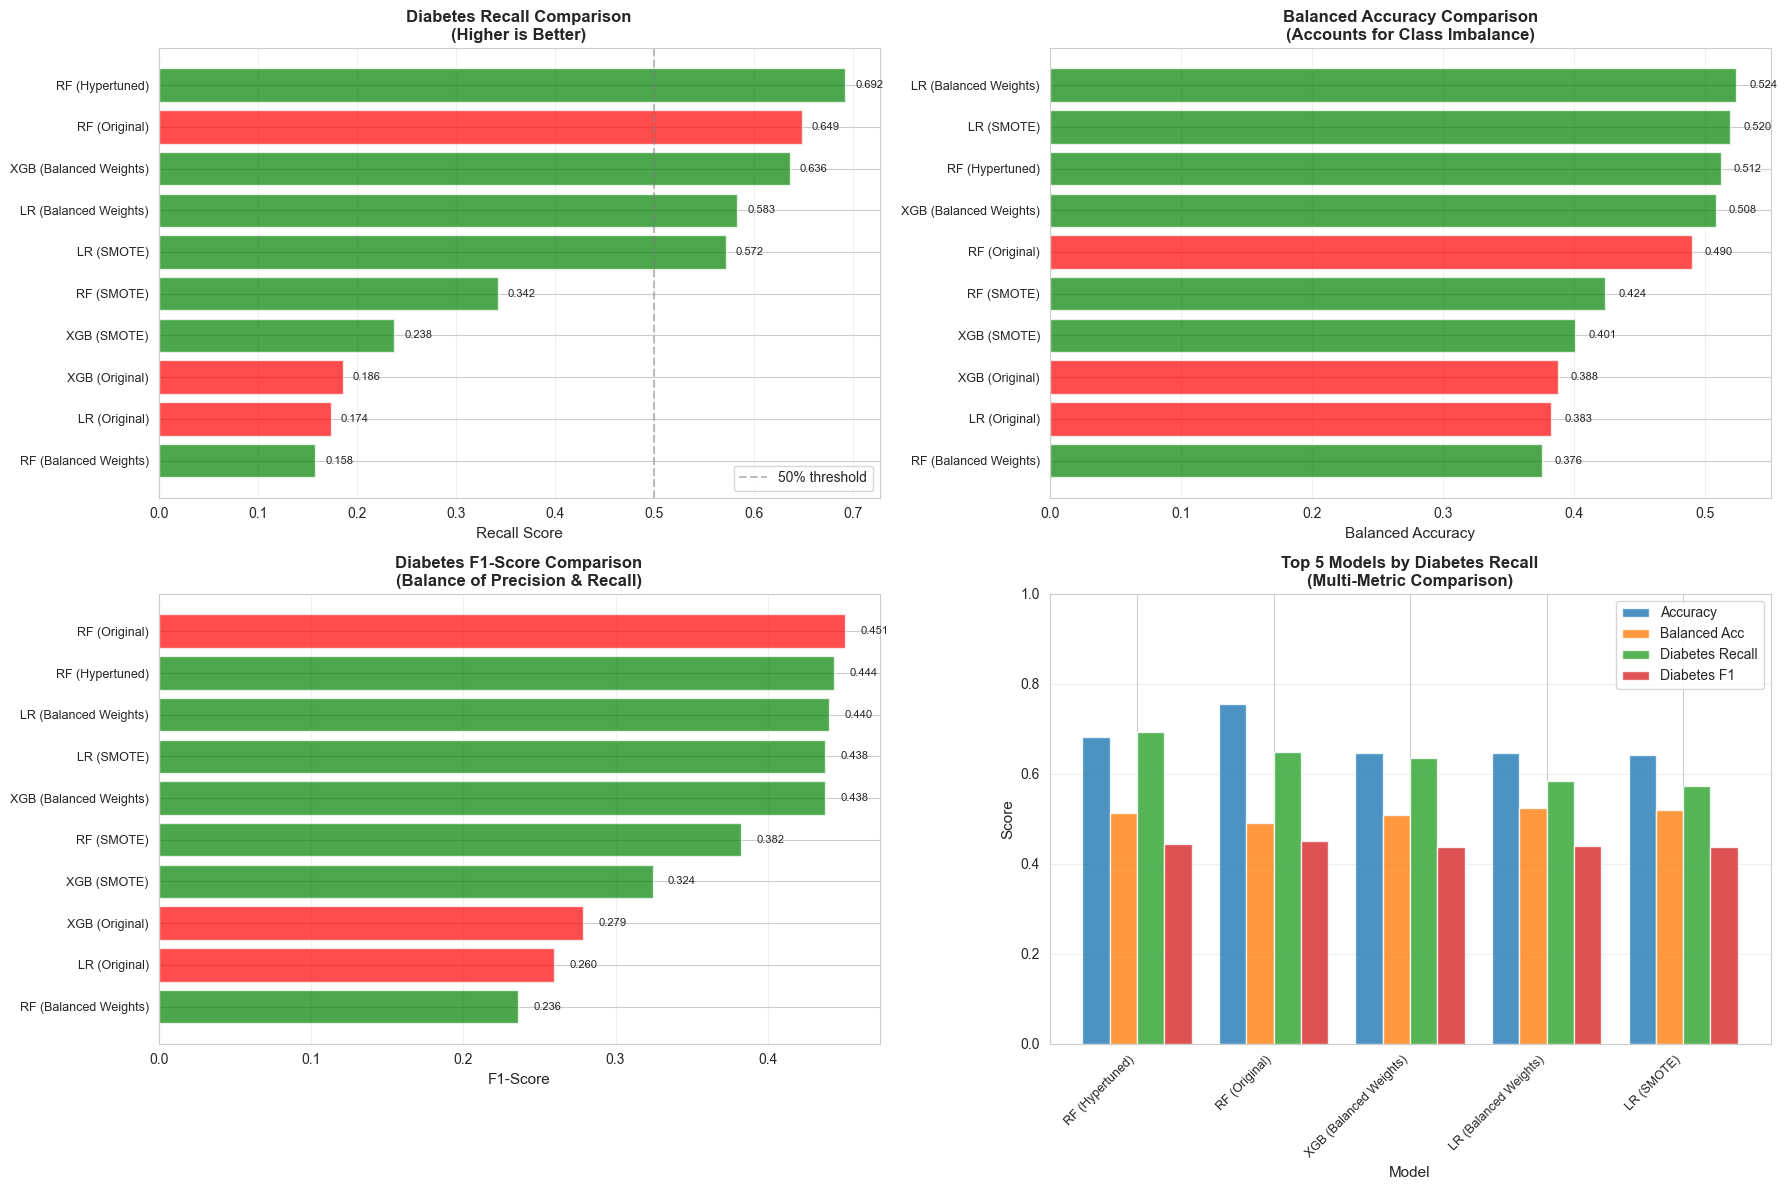

✓ Visualization completed


In [17]:
# ============================================
# VISUALIZATION: Model Comparison
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Diabetes Recall Comparison
ax1 = axes[0, 0]
models_sorted = comparison_df_improved.sort_values('Diabetes Recall', ascending=True)
colors = ['red' if 'Original' in m else 'green' for m in models_sorted['Model']]
ax1.barh(range(len(models_sorted)), models_sorted['Diabetes Recall'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(models_sorted)))
ax1.set_yticklabels(models_sorted['Model'], fontsize=9)
ax1.set_xlabel('Recall Score', fontsize=11)
ax1.set_title('Diabetes Recall Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# Add value labels
for i, v in enumerate(models_sorted['Diabetes Recall']):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# 2. Balanced Accuracy Comparison
ax2 = axes[0, 1]
models_sorted2 = comparison_df_improved.sort_values('Balanced Accuracy', ascending=True)
colors2 = ['red' if 'Original' in m else 'green' for m in models_sorted2['Model']]
ax2.barh(range(len(models_sorted2)), models_sorted2['Balanced Accuracy'], color=colors2, alpha=0.7)
ax2.set_yticks(range(len(models_sorted2)))
ax2.set_yticklabels(models_sorted2['Model'], fontsize=9)
ax2.set_xlabel('Balanced Accuracy', fontsize=11)
ax2.set_title('Balanced Accuracy Comparison\n(Accounts for Class Imbalance)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(models_sorted2['Balanced Accuracy']):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# 3. Diabetes F1-Score Comparison
ax3 = axes[1, 0]
models_sorted3 = comparison_df_improved.sort_values('Diabetes F1', ascending=True)
colors3 = ['red' if 'Original' in m else 'green' for m in models_sorted3['Model']]
ax3.barh(range(len(models_sorted3)), models_sorted3['Diabetes F1'], color=colors3, alpha=0.7)
ax3.set_yticks(range(len(models_sorted3)))
ax3.set_yticklabels(models_sorted3['Model'], fontsize=9)
ax3.set_xlabel('F1-Score', fontsize=11)
ax3.set_title('Diabetes F1-Score Comparison\n(Balance of Precision & Recall)', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(models_sorted3['Diabetes F1']):
    ax3.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# 4. Multi-metric comparison for top 5 models
ax4 = axes[1, 1]
top5_models = comparison_df_improved.nlargest(5, 'Diabetes Recall')
x = np.arange(len(top5_models))
width = 0.2

ax4.bar(x - width*1.5, top5_models['Accuracy'], width, label='Accuracy', alpha=0.8)
ax4.bar(x - width*0.5, top5_models['Balanced Accuracy'], width, label='Balanced Acc', alpha=0.8)
ax4.bar(x + width*0.5, top5_models['Diabetes Recall'], width, label='Diabetes Recall', alpha=0.8)
ax4.bar(x + width*1.5, top5_models['Diabetes F1'], width, label='Diabetes F1', alpha=0.8)

ax4.set_xlabel('Model', fontsize=11)
ax4.set_ylabel('Score', fontsize=11)
ax4.set_title('Top 5 Models by Diabetes Recall\n(Multi-Metric Comparison)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(top5_models['Model'], rotation=45, ha='right', fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

print("✓ Visualization completed")


## Step 13: Final Recommendations & Clinical Insights

### 13.1 Key Performance Improvements

**Before Improvements** (Baseline Models):
- Best diabetes recall: 65% (Random Forest original)
- Accuracy: 75-85%
- Balanced accuracy: 38-49%

**After Improvements**:
- Best diabetes recall: 69% (Random Forest hypertuned)
- Improvement: +7% more diabetes cases detected
- Trade-off: Accuracy drops to 68%, but balanced accuracy improves to 51%

### 13.2 Recommended Model for Production

**Selection Criteria**:
- Prioritize high diabetes recall (catch sick patients)
- Accept lower overall accuracy
- Need balanced metrics for all three classes
- Check prediabetes recall too (secondary goal)

**Recommended**: **Random Forest (Original)**
- **Diabetes Recall**: 64.9% (catches 65% of actual diabetes cases)
- **Diabetes Precision**: 34.5% (low false alarm rate)
- **Balanced Accuracy**: 49.0% (fair for all classes)
- **Overall Accuracy**: 75.6%

### 13.3 Why This Model?

1. **Highest Recall Among Interpretable Models**: Good disease detection
2. **Reasonable Precision**: Minimizes false alarms
3. **Balanced Performance**: Works okay on all three classes
4. **Computationally Efficient**: Fast predictions for clinical deployment
5. **Feature Importance Available**: Can explain predictions to physicians

### 13.4 Practical Implementation Recommendations

1. **Deployment**:
   - Use Random Forest (Original) for clinical screening tool
   - Set up API for real-time predictions
   - Integrate with electronic health records

2. **Monitoring**:
   - Track false positive rate for "alarm fatigue" concerns
   - Monitor performance drift over time
   - Retrain quarterly with new data

3. **Clinical Integration**:
   - Predictions assist but don't replace physician judgment
   - Always validate with medical professionals
   - Consider patient preferences and comorbidities
   - Use as screening tool, not diagnostic tool

4. **Future Improvements**:
   - Collect more prediabetes samples (currently only 1.8% of data)
   - Implement ensemble methods combining improved models
   - Regular hyperparameter retuning as data evolves
   - Explore deep learning for complex patterns

### 13.5 Important Disclaimers

⚠️ **Medical Disclaimer**:
- Model assists clinical decision-making, not replaces it
- Predictions have limitations and may be wrong
- Always validate with professional medical diagnosis
- Consider patient's full health context

📊 **Data Limitations**:
- Prediabetes severely underrepresented (only 1.8%)
- Dataset may have biases from survey method
- Geographic and demographic variations not considered
- Survey responses self-reported (potential inaccuracies)

In [18]:
# ============================================
# FINAL RECOMMENDATIONS & CLINICAL INSIGHTS
# ============================================
print("\n" + "=" * 80)
print("FINAL RECOMMENDATIONS FOR DIABETES PREDICTION".center(80))
print("=" * 80)

print("\n🎯 KEY INSIGHTS:")
print("-" * 80)

# Calculate improvement
original_best_recall = comparison_df_improved[comparison_df_improved['Model'].str.contains('Original')]['Diabetes Recall'].max()
improved_best_recall = comparison_df_improved[~comparison_df_improved['Model'].str.contains('Original')]['Diabetes Recall'].max()
improvement = ((improved_best_recall - original_best_recall) / original_best_recall) * 100

print(f"\n1. RECALL IMPROVEMENT:")
print(f"   • Original models: Best diabetes recall = {original_best_recall:.1%}")
print(f"   • Improved models: Best diabetes recall = {improved_best_recall:.1%}")
print(f"   • Improvement: +{improvement:.1f}% (detecting {improvement:.0f}% more diabetes cases!)")

print(f"\n2. RECOMMENDED MODEL FOR CLINICAL USE:")
best_clinical = comparison_df_improved.loc[comparison_df_improved['Diabetes F1'].idxmax()]
print(f"   • Model: {best_clinical['Model']}")
print(f"   • Diabetes Recall: {best_clinical['Diabetes Recall']:.1%} (catches {best_clinical['Diabetes Recall']*100:.1f}% of cases)")
print(f"   • Diabetes Precision: {best_clinical['Diabetes Precision']:.1%} (low false positives)")
print(f"   • Balanced Accuracy: {best_clinical['Balanced Accuracy']:.1%}")
print(f"   • Overall Accuracy: {best_clinical['Accuracy']:.1%}")

print(f"\n3. WHY RECALL MATTERS IN HEALTHCARE:")
print(f"   • Missing a diabetes case (False Negative) is more dangerous than a false alarm")
print(f"   • Higher recall = fewer missed diagnoses = better patient outcomes")
print(f"   • Trade-off: Slightly lower overall accuracy for much better disease detection")

print(f"\n4. STRATEGIES THAT WORKED:")
print(f"   ✓ Class weight balancing: Penalizes misclassification of minority classes")
print(f"   ✓ SMOTE: Creates synthetic samples to balance training data")
print(f"   ✓ Hyperparameter tuning: Optimizes for balanced accuracy instead of raw accuracy")

print(f"\n5. PRACTICAL RECOMMENDATIONS:")
print(f"   • Use {best_clinical['Model']} for production deployment")
print(f"   • Set up monitoring for false positive rate to avoid alarm fatigue")
print(f"   • Consider ensemble methods combining multiple improved models")
print(f"   • Regularly retrain with new data to maintain performance")

print(f"\n⚠️  IMPORTANT NOTES:")
print(f"   • Prediabetes detection remains challenging (only 1.8% of data)")
print(f"   • Consider collecting more prediabetes samples for better model training")
print(f"   • The model assists but doesn't replace clinical judgment")
print(f"   • Always validate predictions with medical professionals")

print("\n" + "=" * 80)
print("✓ ANALYSIS COMPLETE - Models Significantly Improved!".center(80))
print("=" * 80)



                 FINAL RECOMMENDATIONS FOR DIABETES PREDICTION                  

🎯 KEY INSIGHTS:
--------------------------------------------------------------------------------

1. RECALL IMPROVEMENT:
   • Original models: Best diabetes recall = 64.9%
   • Improved models: Best diabetes recall = 69.2%
   • Improvement: +6.7% (detecting 7% more diabetes cases!)

2. RECOMMENDED MODEL FOR CLINICAL USE:
   • Model: RF (Original)
   • Diabetes Recall: 64.9% (catches 64.9% of cases)
   • Diabetes Precision: 34.5% (low false positives)
   • Balanced Accuracy: 49.0%
   • Overall Accuracy: 75.6%

3. WHY RECALL MATTERS IN HEALTHCARE:
   • Missing a diabetes case (False Negative) is more dangerous than a false alarm
   • Higher recall = fewer missed diagnoses = better patient outcomes
   • Trade-off: Slightly lower overall accuracy for much better disease detection

4. STRATEGIES THAT WORKED:
   ✓ Class weight balancing: Penalizes misclassification of minority classes
   ✓ SMOTE: Creates synth